##  Four State Model
-------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg
from scipy.integrate import odeint
sns.set()
%matplotlib inline

Following is the two state simultaneous model. States E1 to R4 represents the exchenger with 
- (1) calcium bound on the internal membrane side (E1)
- (2) calcium bound on the extrnal membrane (E2)
- (3) no calcium bound in hte external side (E3)
- (4) no calcium bound in the internal side (E4)

For the consecutive model,
 - Only those fraction of the states E3 and E4 will undergo translocation which have bound three sodium ions
 - Only those fractions of the states E1 and E2 will bind calcium which have no bound sodium ions

<img src = "img/4.png" height=300px width=300px> <img>

#### Transition Matrix

|states|E1|E2|E3|E4
|--|--|--|--|--|
|E1|1-(k1+k8) |k1 |0 |k8|
|E2|k2 |1-(k2+k3) |k3|0|
|E3|0 |k4|1-(k4+k5) |k5|
|E4|k7 |0 |k6 |1-(k7+k6)|


#### Differential Equations

$\frac{dE_{1}}{dt} = k_{2}E_{2} + k_{7}E_{4} - (k_{1}+k_{8})E_{1}$

$\frac{dE_{2}}{dt} = k_{4}E_{3} + k_{1}E_{1} - (k_{2}+k_{3})E_{2}$

$\frac{dE_{3}}{dt} = k_{3}E_{2} + k_{6}E_{4} - (k_{4}+k_{5})E_{3}$

$\frac{dE_{4}}{dt} = k_{8}E_{1} + k_{5}E_{3} - (k_{7}+k_{6})E_{4}$

Using, $ E_4 = 1 - E_1 - E_2 - E_3 $

#### Numerical Method (Dif. Eqn)

$\frac{dE_{1}}{dt} = - (k_{1}+k_{8} + k_{7})E_{1} + (k_{2}-k_{7})E_{2}- k_{7}E_{3} + k_{7}$

$\frac{dE_{2}}{dt} =  k_{1}E_{1} - (k_{2}+k_{3})E_{2}+ k_{4}E_{3}$

$\frac{dE_{3}}{dt} =  - k_{6}E_{1} + (k_{3}- k_{6})E_{2} - (k_{4}+k_{5} + k_{6})E_{3} + k_{6}$

#### Matrix Equation

$$\begin{pmatrix}
-(k_{1} + k_{8} + k_{7}) & (k_{2}-k_{7}) & -k_{7}\\
k_{1} & - (k_{2}+k_{3}) & k_{4} \\
- k_{6} & (k_{3}- k_{6}) & - (k_{4}+k_{5} + k_{6})\\
\end{pmatrix} \begin{pmatrix}
E_{1}\\
E_{2}\\
E_{3}\\
\end{pmatrix} = \begin{pmatrix}
-k_{7}\\
0\\
-k_{6}\\
\end{pmatrix}$$

-----------

In [26]:
1e5

100000.0

### Calculation

#### Turnover Rate

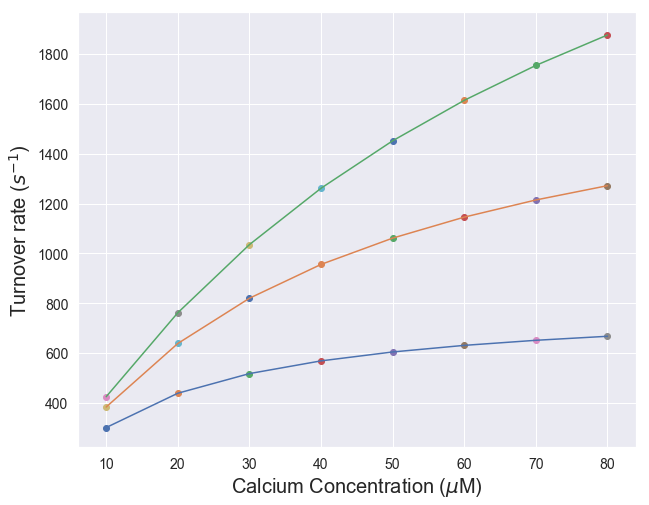

In [37]:
CAO = [10e-3,20e-3,30e-3,40e-3,50e-3,60e-3,70e-3,80e-3]
cao  = [10,20,30,40,50,60,70,80]
NAI = [28e-3,56e-3,140e-3]
plt.figure(figsize = [10,8])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for ni in NAI:
    RNET = []
    for c0 in CAO:
        
        K_em = 50e-3
        K_mn = 28e-3
        K_con = 10e3
        K_coff = 28e3
        K_c = 500*1e3
        K_n = 13e3
        C_0 = c0
        C_i = 0.01e-3
        N_0 = 0.1e-3
        
        N_i = ni
        F_ni = N_i/(N_i+K_mn)
        F_no = N_0/(N_0+K_mn)

        k1 = K_c; k2 = K_c; k3 = K_coff;
        k4 = C_0*K_con*(1-F_no)**3 
        k5 = (K_n*F_no**3)/K_em 
        k6 = (K_n*F_ni**3)*K_em
        k7 = C_i*K_con*(1-F_ni)**3
        k8 = K_coff


        x1 = k2*k4*(k7+k6)+(k5*k7*(k2+k3))
        x2 = (k1*k7*(k4+k5))+(k4*k6*(k1+k8))
        x3 = (k1*k3*(k7+k6))+(k8*k6*(k2+k3))
        x4 = (k2*k8*(k4+k5))+(k3*k5*(k1+k8))
        S = x1+x2+x3+x4

        R_net = abs((x1*k1 - x2*k2)/S)
        RNET.append(R_net*10)
        #print(R_net)
        plt.scatter(c0*1000,R_net*10)
    
    plt.plot(cao,RNET)
plt.xlabel("Calcium Concentration ($\mu$M)",fontsize =20)
plt.ylabel("Turnover rate ($s^{-1}$)",fontsize =20)
plt.show()

#### Simulation

$\frac{dE_{1}}{dt} = - (k_{1}+k_{8} + k_{7})E_{1} + (k_{2}-k_{7})E_{2}- k_{7}E_{3} + k_{7}$

$\frac{dE_{2}}{dt} =  k_{1}E_{1} - (k_{2}+k_{3})E_{2}+ k_{4}E_{3}$

$\frac{dE_{3}}{dt} =  - k_{6}E_{1} + (k_{3}- k_{6})E_{2} - (k_{4}+k_{5} + k_{6})E_{3} + k_{6}$

In [106]:
# function that returns dy/dt
def model(y,t,k):
    
    '''y[0] = E1,
       y[1] = E2,
       y[2] = E3,
    '''
    
    dy1dt = -(k['k1']+k['k8']+k['k7'])*y[0] \
            +(k['k2']-k['k7'])*y[1]\
            - k['k7']*y[2]+ k['k7']
    
    dy2dt = k['k1']*y[0] \
          -(k['k2']+k['k3'])*y[1] \
          + k['k4']*y[2] 
    
    dy3dt = -k['k6']*y[0]\
            +(k['k3']-k['k6'])*y[1]\
            -(k['k4']+k['k5']+k['k6'])*y[2]+ k['k6'] 
    
    dydt = [dy1dt,dy2dt,dy3dt]
    return dydt

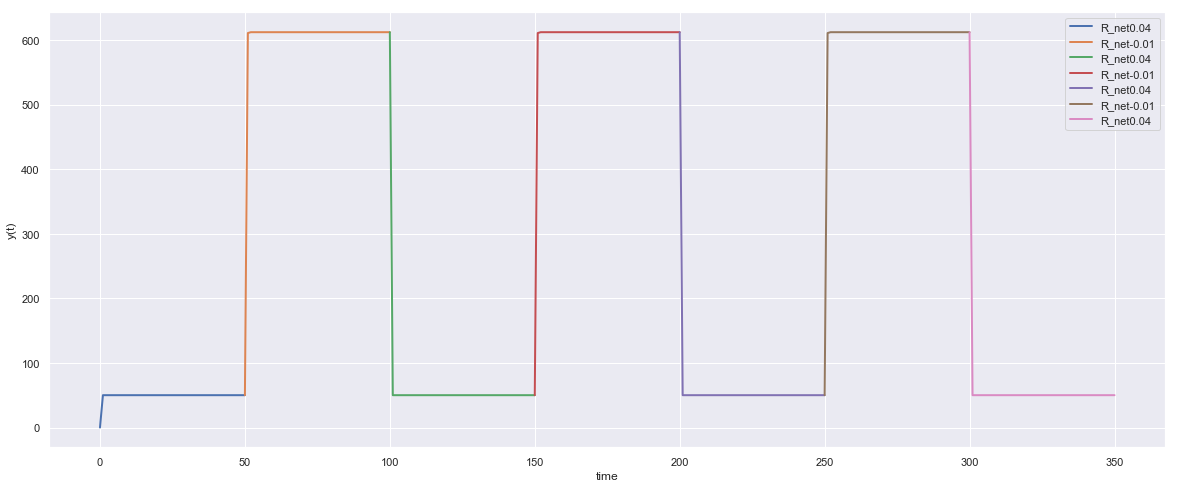

In [112]:
plt.figure(figsize = [20,8])
KEM = [40e-3,-10e-3,40e-3,-10e-3,40e-3,-10e-3,40e-3]
y0 = [0,0,1]
for kem,T in zip(KEM,[0,50,100,150,200,250,300,350]):
        K_em = kem
        K_mn = 28e-3
        K_con = 10e3
        K_coff = 28e3
        K_c = 5e3
        K_n = 10e3
        C_0 = 50e-3
        C_i = 0.01e-3
        N_0 = 0.1e-3
        N_i = 140e-3
        F_ni = N_i/(N_i+K_mn)
        F_no = N_0/(N_0+K_mn)
        k1 = K_c; k2 = K_c; k3 = K_coff;
        k4 = C_0*K_con*(1-F_no)**3; 
        k5 = (K_n*F_no**3)/K_em; 
        k6 = (K_n*F_ni**3)*K_em;
        k7 = C_i*K_con*(1-F_ni)**3;
        k8 = K_coff
        
        k = {'k1':k1,'k2':k2,'k3':k3,\
             'k4':k4,'k5':k5,'k6':k6,\
             'k7':k7,'k8':k8}

        '''solve ODEs'''
        t = np.linspace(T,T+50)
        y = odeint(model,y0,t,args=(k,))
        y1 = np.empty_like(t)
        y2 = np.empty_like(t)
        y3 = np.empty_like(t)
        y4 = np.empty_like(t)
        R_net = np.empty_like(t)
        for i in range(len(t)):
            y1[i] = y[i][0]
            y2[i] = y[i][1]
            y3[i] = y[i][2]
            y4[i] = 1 - y1[i] - y2[i] - y3[i] 
        R_net = abs(y1*k1 - y2*k2)
        
        y0 = [y1[50-1],y2[50-1],y3[50-1]]
        
        '''Plot the simulation'''
        plt.plot(t,R_net,linewidth=2,label='R_net'+str(kem))
        #plt.plot(t,y1,linewidth=2,label='y1'+str(kem))
        #plt.plot(t,y2,linewidth=2,label='y2'+str(kem))
        plt.xlabel('time')
        plt.ylabel('y(t)')
        plt.legend()
plt.show()

#### Analytical Solution

In [8]:
x1 = k2*k4*(k7+k6)+k5*k7*(k2+k3)
x2 = k1*k7*(k4+k5)+k4*k6*(k1+k8)
x3 = k1*k3*(k7+k6)+k8*k6*(k2+k3)
x4 = k2*k8*(k4+k5)+k3*k5*(k1+k8)

In [9]:
x1,x2,x3,x4

(1.940105102593134, 4.374711827520394, 1361129.6283434846, 4260313.021776008)

In [10]:
s = x1+x2+x3+x4
E1 = x1/s
E2 = x2/s
E3 = x3/s
E4 = x4/s
E1,E2,E3,E4

(3.4512544980741915e-07,
 7.782178322364029e-07,
 0.24213145700218566,
 0.7578674196545323)